In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.ops import MLP
from tqdm.notebook import trange

* Write a validation step
* Experiment with `MLP` options
* Implement a CNN

Data: X.shape=(2000, 64, 64) Y.shape=(2000, 5)


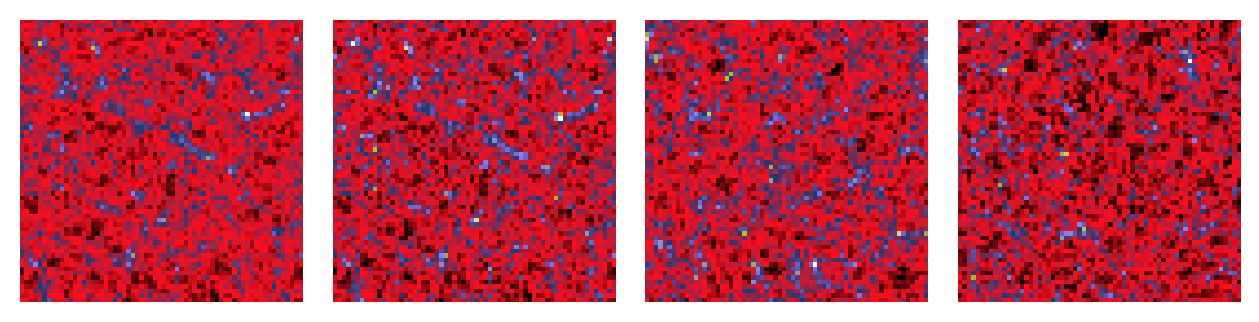

In [2]:
# Cosmology parameters
parameter_names = [
    "$\Omega_m$", "$\Omega_b$", "$h_m$", "$n_s$", "$\sigma_8$"
]

# Fiducial cosmology of Quijote
alpha = np.array([0.3175, 0.0490, 0.6711, 0.9624, 0.8340])

# Quijote hypercube bounds
lower = np.array([0.10, 0.03, 0.50, 0.80, 0.60])
upper = np.array([0.50, 0.07, 0.90, 1.20, 1.00])

data_dir = "data/"
X = np.load(os.path.join(data_dir, "density_fields_x64.npy"))
Y = np.load(os.path.join(data_dir, "field_parameters.npy"))

print(f"Data: {X.shape=} {Y.shape=}")

fig, axs = plt.subplots(1, 4, dpi=200)
for i, ax in enumerate(axs):
    # A, B = Y[i]
    # ax.set_title(f"{A=:.1f}, {B=:.1f}")
    im = ax.imshow(X[i], cmap="gist_stern")
    ax.axis("off")
# plt.colorbar(im)
plt.tight_layout()
plt.show()

In [3]:
# Data
data_dim = np.prod(X.shape[1:])
parameter_dim = Y.shape[-1]
# Model
H = [1024, 512, 128]
activation = nn.Tanh
# Optimisation
n_steps = 10_000
lr = 1e-3
batch_size = 400

# Experiment with args here
net = MLP(
    data_dim, 
    H + [parameter_dim], 
    activation_layer=activation,
    bias=True,
    dropout=0.3
)

In [4]:
def convert(x):
    return torch.as_tensor(x).float()

def get_data(n):
    ix = np.random.randint(len(X), size=(n,))
    return convert(X[ix]).flatten(1), convert(Y[ix])

In [5]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

losses = []
with trange(n_steps) as steps:
    for s in steps:
        x, y = get_data(batch_size)

        loss = loss_fn(net(x), y)
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        losses += [loss.item()]
        steps.set_postfix(loss=f"{loss:.3E}")

  0%|          | 0/10000 [00:00<?, ?it/s]

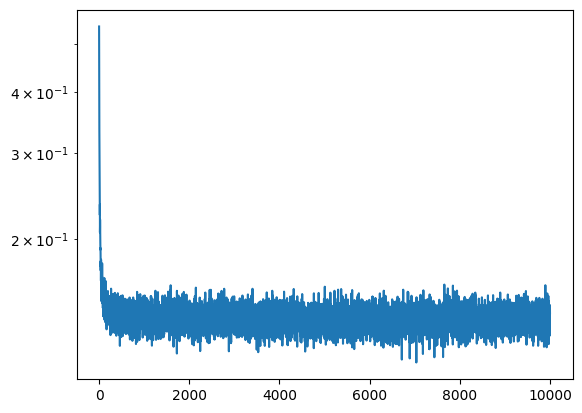

In [6]:
plt.semilogy(losses)
plt.show()

In [7]:
mean = np.load(os.path.join(data_dir, "density_fields_fiducials_x64.npy")).mean(axis=0)
covariance = np.load(os.path.join(data_dir, "covariance_x64.npy"))

data = np.random.multivariate_normal(mean.flatten(), covariance)

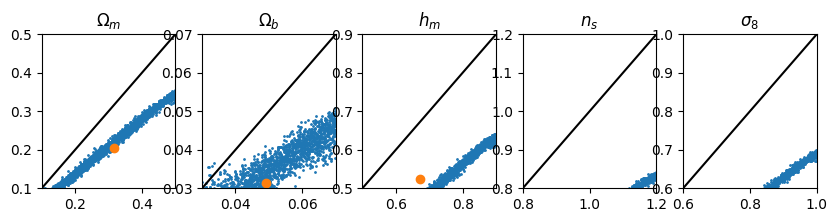

In [8]:
net = net.eval()

Y__ = net(convert(data)).detach().numpy()
Y_ = net(convert(X).flatten(1)).detach().numpy()

fig, axs = plt.subplots(1, len(alpha), figsize=(10., 2.))
for i, ax in enumerate(axs.ravel()):
    ax.set_title(parameter_names[i])
    ax.scatter(Y[:, i], Y_[:, i], s=1.)
    ax.scatter(alpha[i], Y__[i])
    ax.set_xlim(lower[i], upper[i])
    ax.set_ylim(lower[i], upper[i])
    ax.axline((0, 0), slope=1, color="k")
plt.show()

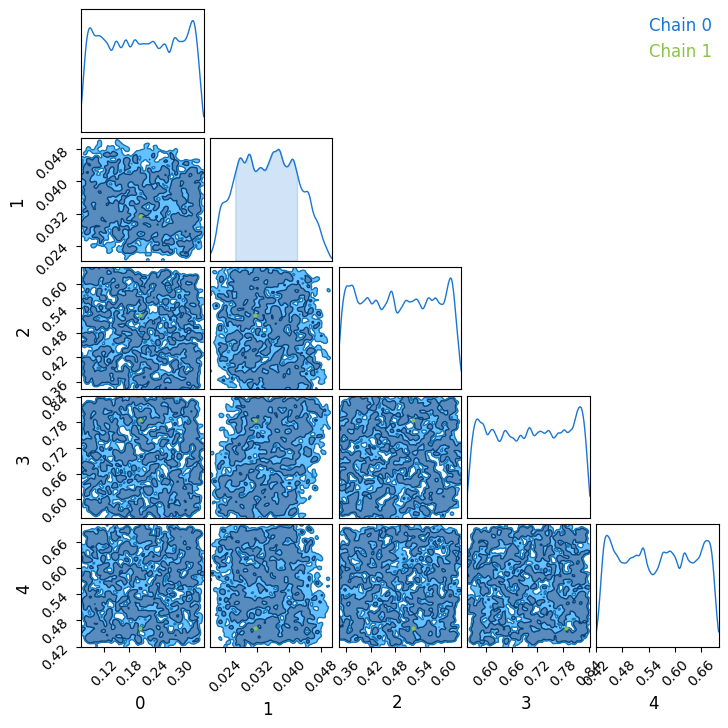

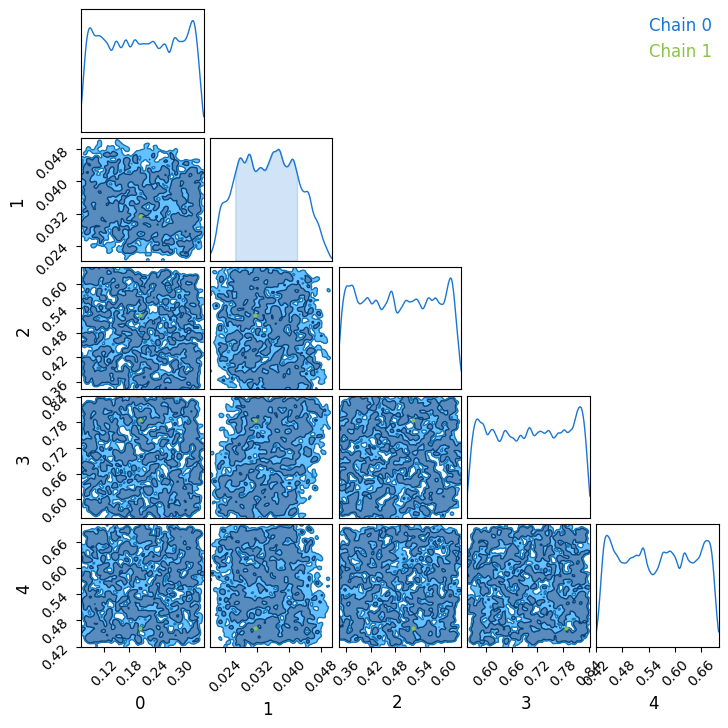

In [9]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(Y_)
c.add_marker(Y__)
c.plotter.plot()

In [10]:
# Save output summaries for simulations + data
np.save(os.path.join(data_dir, "nn_summary_data.npy"), Y__)
np.save(os.path.join(data_dir, "nn_summaries.npy"), Y_)